In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm,rc
import matplotlib.colors as colors
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from fredpy import series, window_equalize
import collections

%matplotlib inline

In [2]:
# # Import daily interest rate data 
y1m= series('DTB4WK')
y3m= series('DTB3')
y6m= series('DTB6')
y1 = series('DGS1')
y5 = series('DGS5')
y10= series('DGS10')
y20= series('DGS20')
y30= series('DGS30')

# Set the date ranges for the data
for x in [y1m,y3m,y6m,y1,y5,y10,y20,y30]:
    x.window(['2003-01-01','2016-03-31'])

In [3]:
# Form individual data frames and the full data frame
y1mFrame= pd.DataFrame({'y1m':y1m.data},index=y1m.datenumbers)
yFrame=  pd.DataFrame({'temp':np.nan+y3m.data},index=y3m.datenumbers)
y3mFrame= pd.DataFrame({'y3m':y3m.data},index=y3m.datenumbers)
y3mFrame= pd.DataFrame({'y3m':y3m.data},index=y3m.datenumbers)
y6mFrame= pd.DataFrame({'y6m':y6m.data},index=y6m.datenumbers)
y1Frame = pd.DataFrame({'y1':y1.data},index=y1.datenumbers)
y5Frame = pd.DataFrame({'y5':y5.data},index=y5.datenumbers)
y10Frame= pd.DataFrame({'y10':y10.data},index=y10.datenumbers)
y20Frame= pd.DataFrame({'y20':y20.data},index=y20.datenumbers)
y30Frame= pd.DataFrame({'y30':y30.data},index=y30.datenumbers)

df = pd.concat([y1mFrame,y3mFrame,y6mFrame,y1Frame,y5Frame,y10Frame,y20Frame,y30Frame],axis=1)

# Drop all days for which all rates are nan (national holidays, etc)
df = df.dropna(how='all')
df.head()

df.to_csv('yieldCurveSurface.csv')

In [4]:
# Create a dictionary that records rate data available during specific date ranges
the_dict = {}
d0 = df.index[0]
intervalNumber = 1
for i,ind in enumerate(df.index):
    
    criterion = collections.Counter(df.loc[ind].dropna().index) == collections.Counter(df.loc[d0].dropna().index)
    if criterion ==False:
        
        the_dict['interval '+str(intervalNumber)] = [d0,df.index[i-1],df.loc[d0].dropna().index]
        
        d0 = ind
        intervalNumber+=1
        
the_dict['interval '+str(intervalNumber)] = [d0,df.index[i],df.loc[d0].dropna().index]

# dictionary to link data fram column values to y-axis values
yaxis_dict = {'y1m':0, 'y3m':1, 'y6m':2, 'y1':3, 'y5':4, 'y10':5, 'y20':6, 'y30':7}

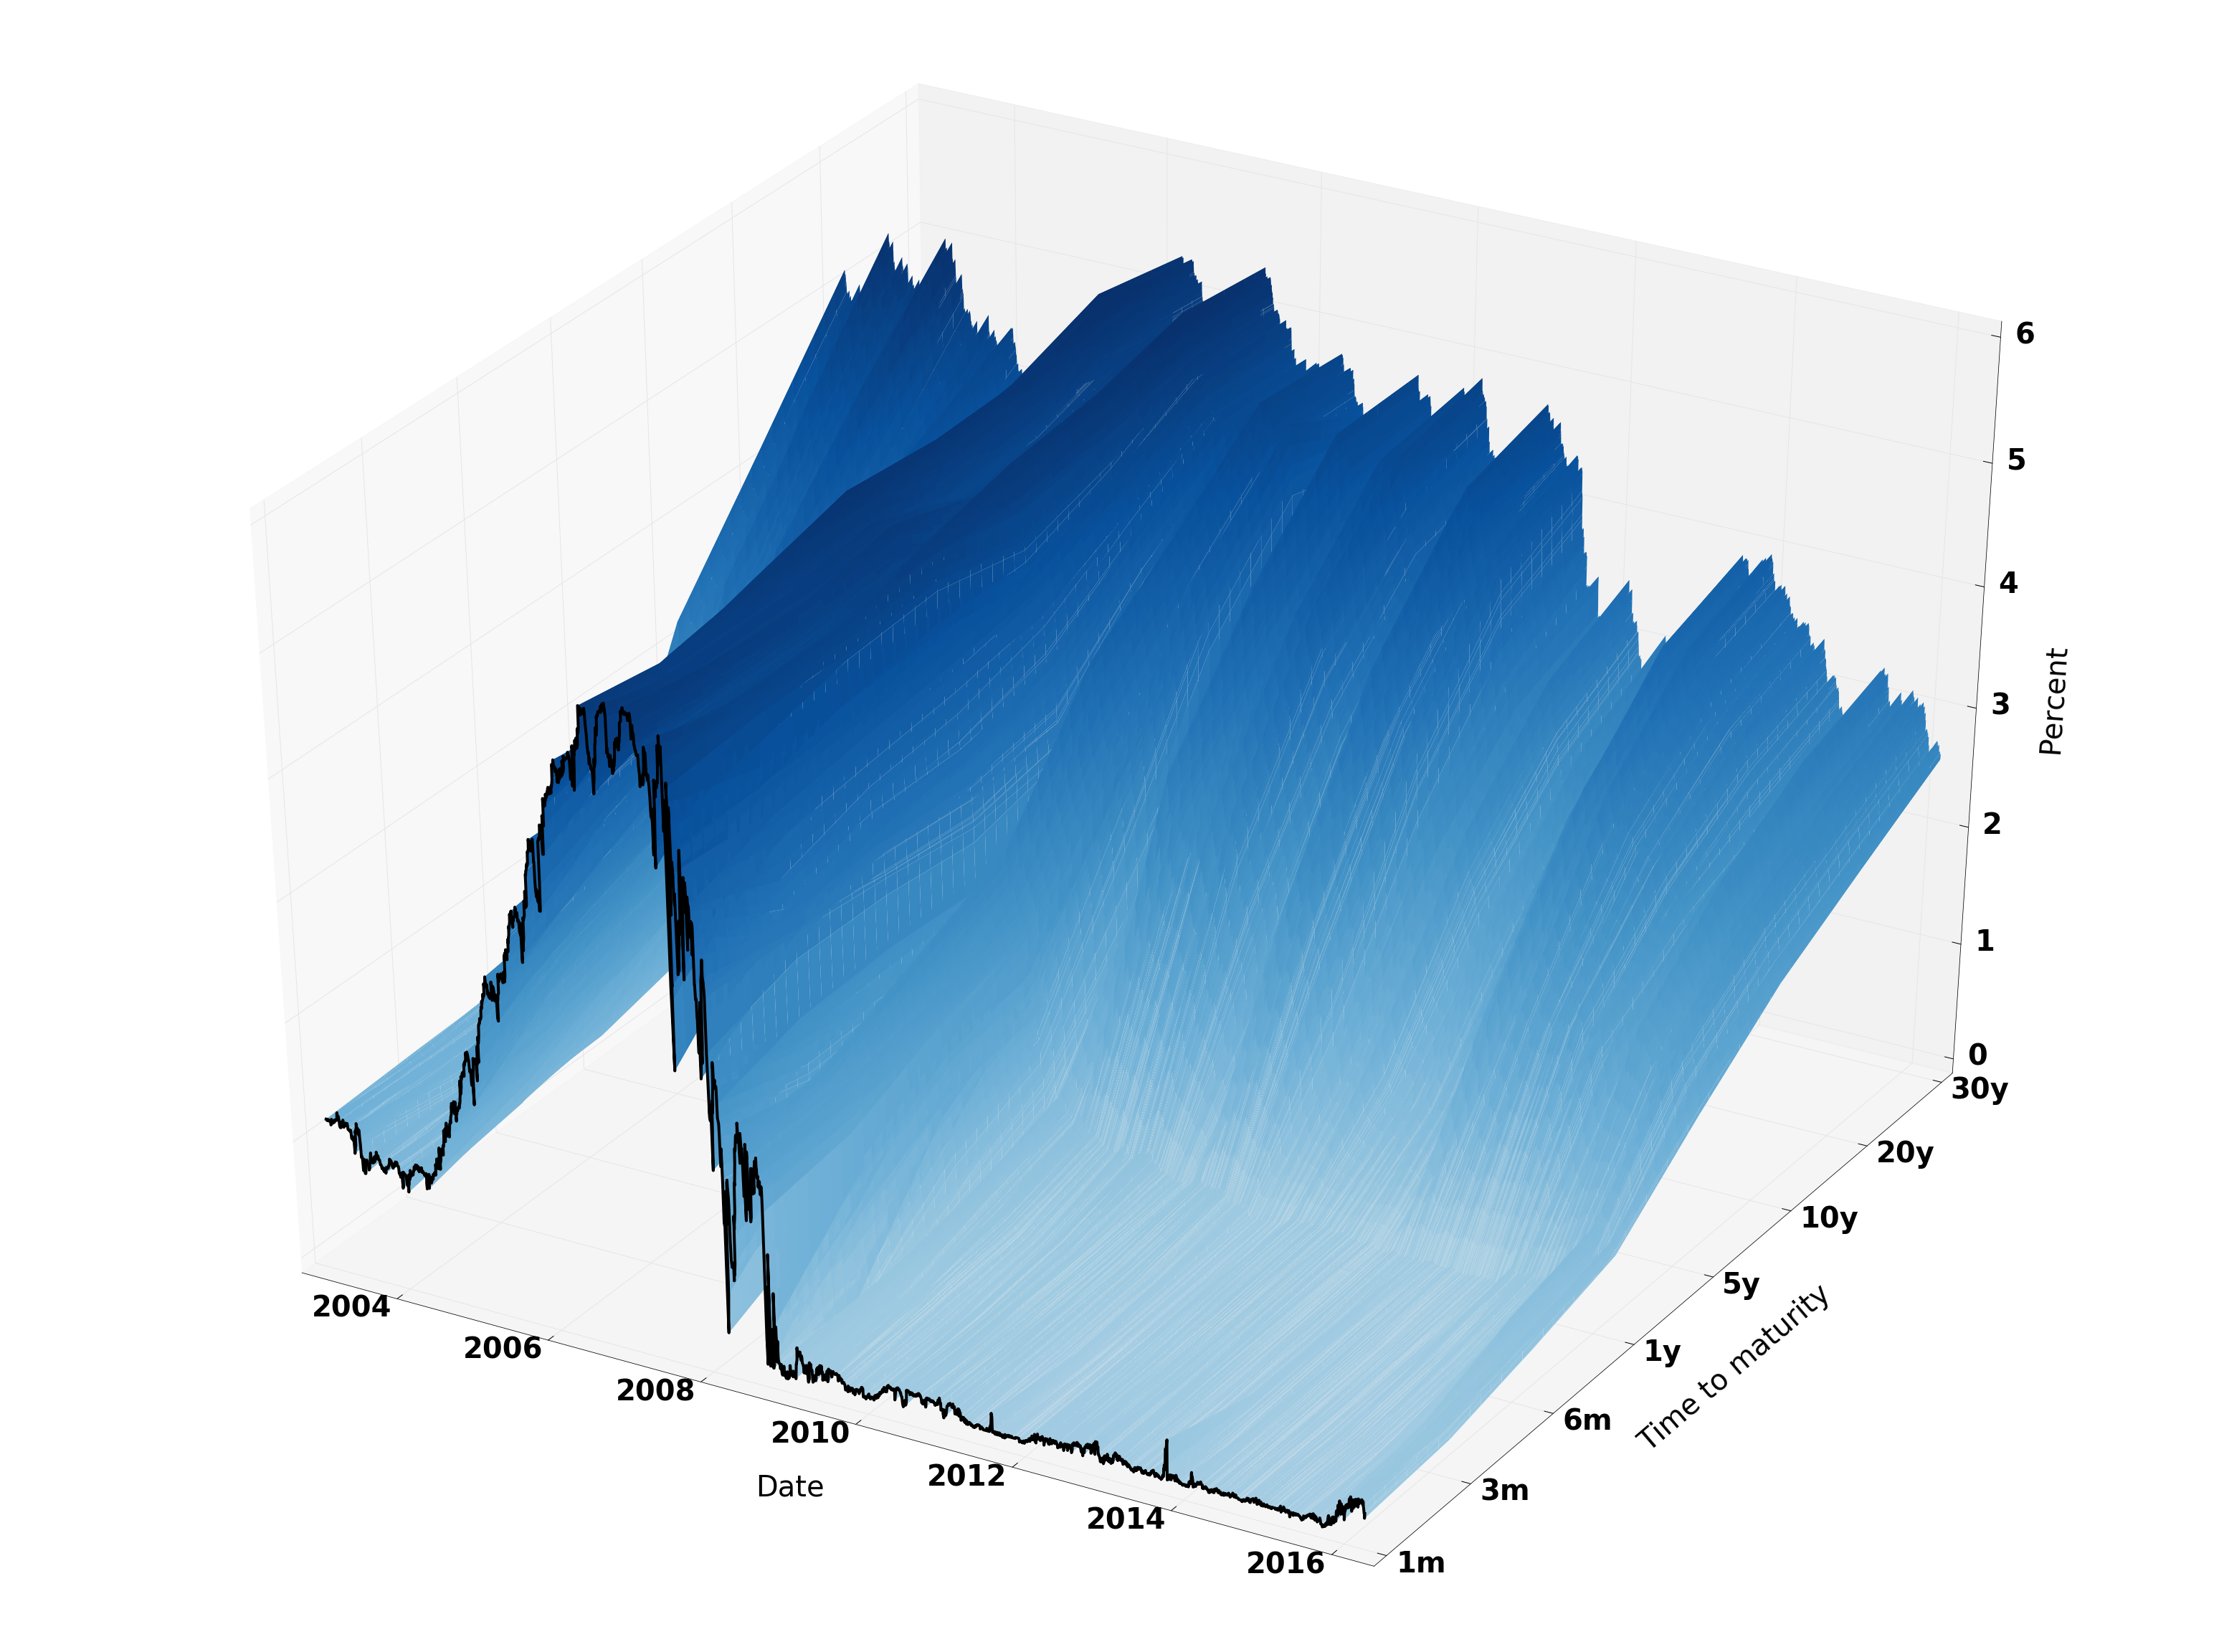

In [5]:
# Set plot properties and define a date locator
font = {'weight' : 'bold',
        'size'   : 40}

rc('font', **font)
years1,years2,years5,years10= [mdates.YearLocator(tspace) for tspace in [1,2,5,10]]


# Create the figure
fig = plt.figure(figsize=(44,33))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([mdates.date2num(ex) for ex in df.index][0],[mdates.date2num(ex) for ex in df.index][-1])
ax.set_zlim([0,10])

# Iterate over the different date ranges
for key in the_dict.keys():
    
    # Create the subset of the dataframe
    start = the_dict[key][0]
    end = the_dict[key][1]
    cols = the_dict[key][2]

    df_subset = df[cols].loc[start:end]
    
    # Add extra columns to interpolate
    nExtra=7
    tempNumber =0
    nColumns = len(df_subset.columns)
    originalColumns = df_subset.columns
    for j in range(nColumns-1):
    
        for k in range(nExtra):

            df_subset.insert(loc=nColumns-j-1,column='tmp '+str(tempNumber),value = np.nan*df_subset[df_subset.columns[0]])
            tempNumber +=1

    df_subset = df_subset.interpolate(axis=1)

    # y-axis values
    yAxisValues = []
    for k,col in enumerate(originalColumns[:-1]):

        yAxisValues.append(yaxis_dict[col])

        for l in range(nExtra):

            yAxisValues.append(yaxis_dict[col]+(l+1)*(yaxis_dict[originalColumns[k+1]]-yaxis_dict[originalColumns[k]])/(nExtra+1))
            
    yAxisValues.append(yaxis_dict[originalColumns[-1]])
    
    # Create the plot
    x,y = np.meshgrid([mdates.date2num(ex) for ex in df_subset.index], yAxisValues)
    z = np.transpose(df_subset.values)

    ax.plot_surface(x, y,z,lw=0,rstride=1,cstride=1,norm=colors.Normalize(vmin=-3, vmax=z.max()),cmap=cm.Blues)
    ax.plot(x[0], y[0],df_subset[df_subset.columns[0]],lw=4,color='k')
    

    xtick_locator = mdates.AutoDateLocator()
    xtick_formatter = mdates.AutoDateFormatter(xtick_locator)

    ax.xaxis.set_major_locator(years2)
    ax.xaxis.set_major_formatter(xtick_formatter)

ax.view_init(elev=35, azim=None)

ax.set_zlim([0,6])
ax.set_yticks([0,1,2,3,4,5,6,7])
ax.set_yticklabels(['1m','3m','6m','1y','5y','10y','20y','30y'])

ax.xaxis._axinfo['tick']['inward_factor'] = 0
ax.yaxis._axinfo['tick']['inward_factor'] = 0
ax.zaxis._axinfo['tick']['inward_factor'] = 0

[t.set_va('center') for t in ax.get_yticklabels()]
[t.set_ha('left') for t in ax.get_yticklabels()]
[t.set_va('center') for t in ax.get_xticklabels()]
[t.set_ha('right') for t in ax.get_xticklabels()]
[t.set_va('center') for t in ax.get_zticklabels()]
[t.set_ha('left') for t in ax.get_zticklabels()]


ax.set_xlabel('Date', labelpad=60.)
ax.set_ylabel('Time to maturity', labelpad=60.)
ax.set_zlabel('Percent', labelpad=45.)


fig.tight_layout()

plt.savefig('yield_curve_surface.png',bbox_inches='tight',dpi=120)